#### Sparisity Comparison version of RadixNet.ipynb
This program copies the RadiXNet implementation from RadixNet.ipynb, but instead uses it to create multiple networks with differing sparsities to compare the difference in accuracies between sparsities

## Imports

In [3]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_model_optimization as tfmot
from RadixNetCalc import emr_net, kemr_net
import matlab.engine
import math
import networkx as nx

### Read data

In [4]:
data = pd.read_csv("MNIST/mnist_train.csv") #mnist train
test = pd.read_csv("MNIST/mnist_test.csv") #mnist test
data = np.array(data)
np.random.seed(100)
np.random.shuffle(data) 

data_train = data.T
Y_train = np.array(data_train[0])
X_train = np.array(data_train[1:]).T
X_train = X_train / 255

test = np.array(test)
data_test = test.T
Y_test = np.array(data_test[0])
X_test = np.array(data_test[1:]).T
X_test = X_test / 255

## Create a Mask 
Create using Mask(num_output, input_shape, radix), call using maskname()

In [5]:
class Mask(tf.Module):
    def __init__(self,num_outputs, input_shape, layerval):
        self.count=None
        self.num_outputs = num_outputs
        self.input_shape = input_shape
        self.layerval = layerval
    @tf.function
    def __call__(self):
        if self.count is None:
            #arr = np.zeros(self.input_shape[1:]+(self.num_outputs,))
            arr = self.layerval
            tensor = tf.constant(arr, dtype= tf.float32)
            self.count = tf.Variable(tensor)
        return self.count
        

### RadixLayer

In [6]:
class RadixLayer(layers.Layer):
    def __init__(self, num_outputs, layerval):
        super(RadixLayer,self).__init__()
        self.num_outputs = num_outputs
        self.layerval = layerval
    def build(self, input_shape):
        self.kernel = self.add_weight("kernel", shape = self.layerval.shape, initializer='random_normal', trainable=True)
        #self.b = self.add_weight("b", shape = (self.num_outputs,), initializer='zero', trainable=True)
    def call(self, inputs):
        #print(self.kernel)
        mask = Mask(self.num_outputs, inputs.shape, self.layerval)
        masked = tf.math.multiply(self.kernel,mask())
        #extrazero =  tf.zeros(shape=(self.layerval.shape[0]-inputs.shape[1]), dtype=tf.int32)
        #inputs = tf.concat(inputs,extrazero)
        return tf.matmul(inputs,masked)
        
        

# Create different models based on sparsity

In [11]:
desired = [784,300,100,10]
def calculate_sparsity(sparselayers):
    a = 0
    b = 0
    for layer in sparselayers:
        a += np.count_nonzero(layer)
        b += np.prod(layer.shape)
    return 1 - a/b

sparsemodels = dict()
def findModels():
    N = [[],[]]
    for i in range(1,16):
        N[0].append(i)
        for j in range(1,16):
            N[0].append(j)
            B= []
            for num in desired:
                B.append(math.ceil(num/(i*j)))
            for k in range(1,i*j+1):
                for l in range(len(desired)-3):
                    N[1].append(k)
                #print(N,B)
                try:
                    curlayers = kemr_net(N,B)
                    model = ((tuple(N[0]),tuple(N[1])),tuple(B))
                    sparsemodels[calculate_sparsity(curlayers)] = model
                except:
                    pass
                N[1].clear()
            N[0].pop()
        N[0].pop()
findModels()
#print(sparsemodels)
def createModel(sparsity):
    temp =min(sparsemodels.keys(), key=lambda x: abs(x - sparsity))
    curmodel = sparsemodels[temp]
    N = curmodel[0]
    B = curmodel[1]
    print(N, B)
    desired = [784,300,100,10]
    rlayers = kemr_net(N,B)
    for i in range(len(rlayers)):
        if rlayers[i].shape[0]>desired[i]:
            rlayers[i] = rlayers[i][:desired[i],:]
        if rlayers[i].shape[1]>desired[i+1]:
            rlayers[i] = rlayers[i][:,:desired[i+1]]
    class CustomModel(tf.keras.Model):
        def __init__(self):
            super(CustomModel,self).__init__()
            self.layer1 = RadixLayer(rlayers[0].shape[-1], rlayers[0])
            self.layer2 = RadixLayer(rlayers[1].shape[-1],rlayers[1])
            self.layer3 = RadixLayer(rlayers[2].shape[-1],rlayers[2])
        def call(self, input_tensor):
            x= tf.nn.relu(self.layer1(input_tensor))
            x= tf.nn.relu(self.layer2(x))
            x= tf.nn.softmax(self.layer3(x))
            return x

    sparsity = calculate_sparsity(rlayers)
    print("Sparsity: "+ str(sparsity))
    return CustomModel()
createModel(0.5)

((2, 2), (2,)) (196, 75, 25, 3)
Sparsity: 0.5


<__main__.createModel.<locals>.CustomModel at 0x7f50f8e48610>

### Model compilations

In [12]:
models = []
sparsities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for sparsity in sparsities:
    model = createModel(sparsity)
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    models.append(model)

((7, 1), (7,)) (112, 43, 15, 2)
Sparsity: 0.09659654395191586
((14, 1), (1,)) (56, 22, 8, 1)
Sparsity: 0.10812922614575504
((1, 2), (2,)) (392, 150, 50, 5)
Sparsity: 0.4417731029301277
((1, 2), (2,)) (392, 150, 50, 5)
Sparsity: 0.4417731029301277
((2, 2), (2,)) (196, 75, 25, 3)
Sparsity: 0.5
((1, 3), (1,)) (262, 100, 34, 4)
Sparsity: 0.5915326821938391
((12, 3), (2,)) (22, 9, 3, 1)
Sparsity: 0.695747558226897
((5, 5), (5,)) (32, 12, 4, 1)
Sparsity: 0.8
((15, 12), (60,)) (5, 2, 1, 1)
Sparsity: 0.9157963936889557


### Training

In [7]:
histories = []
for i, model in enumerate(models):
    print("training model with sparsity "+str(sparsities[i]))
    epochs = 5
    history = model.fit(X_train,Y_train,epochs = epochs, batch_size = 100,validation_split = 0.1, verbose = 0)
    histories.append(history)

training model with sparsity 0.1
training model with sparsity 0.2
training model with sparsity 0.3
training model with sparsity 0.4
training model with sparsity 0.5
training model with sparsity 0.6
training model with sparsity 0.7
training model with sparsity 0.8
training model with sparsity 0.9


### Testing

In [8]:
accuracies = []
for model in models:
    accuracies.append(model.evaluate(X_test, Y_test)[1])

313/313 [==============================] - 0s 979us/step - loss: 0.2096 - accuracy: 0.9392


## Plotting accuracy vs. Sparsity

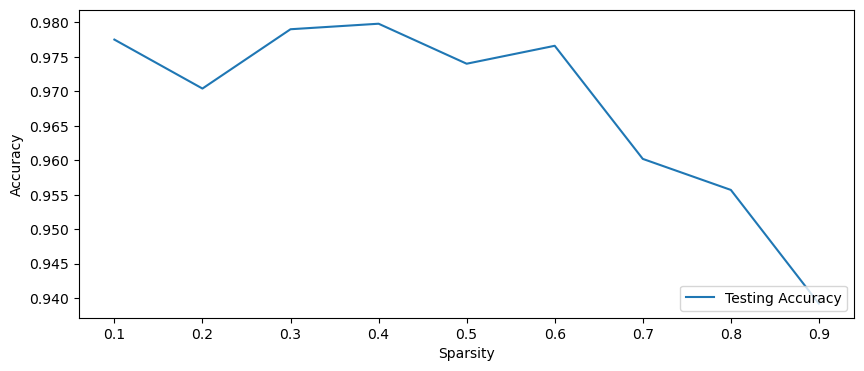

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(sparsities, accuracies, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Sparsity")
plt.ylabel("Accuracy")
plt.show()

### Plotting training accuracies

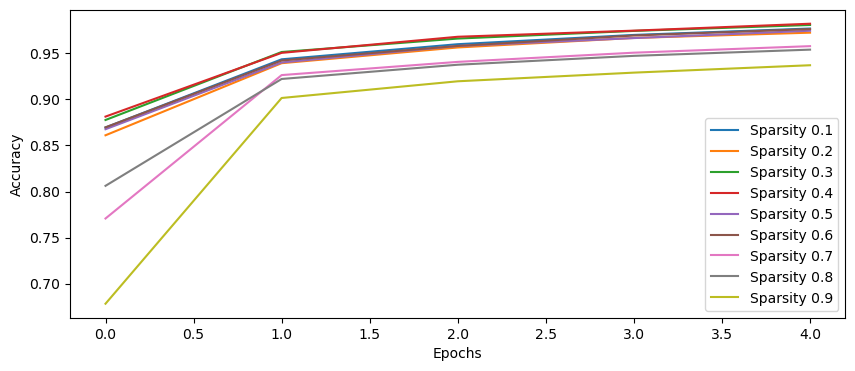

In [10]:
epochs_range = range(epochs)
plt.figure(figsize=(10, 4))
for i, history in enumerate(histories):
    acc = history.history['accuracy']
    
    plt.plot(epochs_range, acc, label='Sparsity '+str(sparsities[i]))
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
    
plt.show()